시작 전 주의!

런타임-런타임 유형 변경-GPU로 바꿔주고 시작합니다.

In [1]:
!pip install transformers

     |████████████████████████████████| 2.3MB 25.0MB/s 
     |████████████████████████████████| 3.3MB 44.8MB/s 
     |████████████████████████████████| 901kB 45.3MB/s 


In [2]:
#주요 패키지들을 불러와줍니다.

import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [174]:
#Torch에서 GPU가 사용되는지 확인하는 코드입니다. 어떤 GPU를 쓰는지 확인할 수 있습니다.

import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


#데이터셋

In [215]:
data = pd.read_csv("2020LectureReview.csv", index_col = 0)
data = data.dropna(axis=0)

In [216]:
# 감성분석 모델링을 위해 별점 1,2점을 받은 리뷰는 0으로, 별점 4,5 점을 받은 리뷰는 1로 대치.
change_value_dict = {100:1, 80:1, 60:60, 40:0, 20:0}
data = data.replace({'ReviewStar':change_value_dict})

# 별점 3점을 받은 리뷰는 감성분석 모델링을 위해 아예 제거
data = data[data.ReviewStar != 60]
data.shape

(64600, 6)

In [217]:
#accuracy 측정할때 문장 길이 상관없이 정확도가 나오는지를 테스트 하기 위해서 글자조정 전 data copy만들어 놓습니다.
data_copy_foraccu2 = data
data_copy_foraccu2 = data_copy_foraccu2.astype({'ReviewStar':'int'})
data_copy_foraccu2.shape

(64600, 6)

In [190]:
#[CLS] [SEP] 토큰 포함 128자 이하의 문장들로 학습시켰습니다.
index = data["ReviewText"].str.len() > 126
data = data.loc[~index]
data.shape

(35453, 6)

In [191]:
data = data.astype({'ReviewStar':'int'})
data

,LectureUrl,LectureName,LectureProf,ReviewStar,ReviewSemester,ReviewText
0,https://yonsei.everytime.kr/lecture/view/3640,INTERNATIONAL MONEY AND CAPITAL MARKETS,함준호,1,20년 1학기 수강자,시험 잘 멋본 것 같은데 에이제로 떠서 놀람 감사합니다 교수님
1,https://yonsei.everytime.kr/lecture/view/3640,INTERNATIONAL MONEY AND CAPITAL MARKETS,함준호,1,20년 1학기 수강자,"에 뭐,,, 그냥 괜찮았는데 자습기간을 안 주고 전범위 시험본다그러니까 당황스러웠네..."
3,https://yonsei.everytime.kr/lecture/view/3640,INTERNATIONAL MONEY AND CAPITAL MARKETS,함준호,1,19년 1학기 수강자,교수님 너무 똑똑하시고 피피티 위주로 수업하시기는 하는데 현장경험이 풍부하셔서 그런...
5,https://yonsei.everytime.kr/lecture/view/943471,학교교실의현장연구방법입문,박순용,0,20년 1학기 수강자,조교가 일을 안하는건지 교수가 일을 안하는건지 강의가 맨날 늦게 올라옴 제 시간에 ...
6,https://yonsei.everytime.kr/lecture/view/943471,학교교실의현장연구방법입문,박순용,0,18년 2학기 수강자,교수님의 수업은 이해하기 쉬웠고 질적연구와 현장연구에 대해 잘 설명해주셔서 수업은 ...
...,...,...,...,...,...,...
38033,https://yonsei.everytime.kr/lecture/view/3053,신경생물학,오영준,0,19년 1학기 수강자,생물을 전공하는 사람이라면 신경생물학에 어느정도 흥미를 갖을 수 있지..그런 흥미를...
38040,https://yonsei.everytime.kr/lecture/view/3053,신경생물학,오영준,1,16년 1학기 수강자,꼭들으세요 인생강의입니다. 생물학과라면 꼭 듣는걸 추천합니다
38041,https://yonsei.everytime.kr/lecture/view/2005288,교육현장연구지도,고래억,1,20년 1학기 수강자,수업 자체는 별론데 교수님이 학생들 참여시키려고 애타게 이름 부르시는게 넘 귀엽고 ...
38042,https://yonsei.everytime.kr/lecture/view/2082636,UT세미나(항노화와여가활동),이록빛,1,20년 1학기 수강자,너무 좋음. 하루만 투자하고 보람찬 한학기 생활을 할 수 있음. 꼭 들으셈


In [195]:
train = data.iloc[:30000]
train.shape

(30000, 6)

In [196]:
test = data.iloc[30000:]
test.shape

(5453, 6)

# 문장별 전처리

Bert 분류 모델은 각 문장의 앞마다 [CLS]를 붙여 인식합니다. 문장 종료는 [SEP]로 알립니다. 이를 처리해줍니다.

In [198]:
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in train.ReviewText]
document_bert[:5]

['[CLS] 시험 잘 멋본 것 같은데 에이제로 떠서 놀람 감사합니다 교수님 [SEP]',
 '[CLS] 에 뭐,,, 그냥 괜찮았는데 자습기간을 안 주고 전범위 시험본다그러니까 당황스러웠네요. 교수님 똑똑하시고 나쁘지 않아요. 다만 3시간 연속인 게 좀 힘들지만 뭐 그건 당연히 고려하시고 신청하시겠죠. [SEP]',
 '[CLS] 교수님 너무 똑똑하시고 피피티 위주로 수업하시기는 하는데 현장경험이 풍부하셔서 그런지 잘 설명해주십니다 저는 정말 좋았어요 [SEP]',
 '[CLS] 조교가 일을 안하는건지 교수가 일을 안하는건지 강의가 맨날 늦게 올라옴 제 시간에 강의를 안 보게 되니까 이 수업에 대한 열정이 초반부터 확 사라짐. 그러면서 저작권 때문에 강의는 일찍 내려야겠다고 함 ㅋㅋ [SEP]',
 '[CLS] 교수님의 수업은 이해하기 쉬웠고 질적연구와 현장연구에 대해 잘 설명해주셔서 수업은 매우 좋았지만, 중간고사 비중이 크고 성적 산출에 있어서 아쉬운 부분이 있습니다. [SEP]']

# 토크나이징
사전학습된 BERT multilingual 모델 내 포함되어있는 토크나이저를 활용하여 토크나이징합니다.

In [199]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]
print(tokenized_texts[0])

['[CLS]', '시', '##험', '잘', '멋', '##본', '것', '같은', '##데', '에', '##이', '##제로', '떠', '##서', '놀', '##람', '감', '##사', '##합', '##니다', '교', '##수', '##님', '[SEP]']


#패딩
token들의 max length보다 크게 max_len 값을 설정합니다. 설정한 max_len만큼 문장 길이에 따른 빈 공간을 0이 채웁니다. 이를 패딩이라 합니다.

In [200]:
# 패딩 작업
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9485,  86834,   9654,   9270,  40419,   8870,  18589,
        28911,   9559,  10739,  53914,   9138,  12424,   9025,  61250,
         8848,  12945,  33188,  48345,   8907,  15891, 108578,    102,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

# 어텐션 마스크
학습 속도를 높이기 위해 실 데이터가 있는 곳과 padding이 있는 곳을 attention에게 알려줍니다.

In [202]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# train-validation set 분리
random state는 일정히 고정합니다.(input과 mask가 섞이지 않기 위함)

In [203]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, train['ReviewStar'].values, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=42, 
                                                       test_size=0.1)

#파이토치 텐서로 변환
numpy ndarray로 되어 있는 inputs, labels, masks들을 torch tensor로 변환합니다.

In [204]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

# 배치 및 데이터로더 설정
현재 쓰고 있는 GPU의 VRAM에 맞도록 배치 사이즈를 설정합니다. 우선 배치사이즈를 크게 넣어보고 VRAM 부족 메세지가 나오면 8의 배수 중 더 작은 것으로 줄여나갑니다.

In [205]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

#테스트셋 전처리
위에서 trainset 전처리 한것과 동일한 과정을  testset에 반복합니다.

In [218]:
#테스트 데이터 전처리 과정
# test = data_copy_foraccu2.iloc[50000:60000] # 여기 주석만 풀어주면 문장길이 상관 없는 감정분석 정확도 확인 가능

sentences = test['ReviewText']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = test['ReviewStar'].values
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

#모델 학습

In [207]:
#GPU 체크 및 할당
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [208]:
#bert 모델 생성

#transformers의 bertforsequenceclassification 모듈 이용.

model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [209]:
# 학습 스케쥴링
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

#학습

In [210]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [211]:
# 아래는 학습 실행 부분입니다.
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   500  of    844.    Elapsed: 0:06:13.

  Average training loss: 0.29
  Training epcoh took: 0:10:27

Running Validation...
  Accuracy: 0.92
  Validation took: 0:00:24

======== Epoch 2 / 4 ========
Training...
  Batch   500  of    844.    Elapsed: 0:06:10.

  Average training loss: 0.16
  Training epcoh took: 0:10:25

Running Validation...
  Accuracy: 0.94
  Validation took: 0:00:24

======== Epoch 3 / 4 ========
Training...
  Batch   500  of    844.    Elapsed: 0:06:10.

  Average training loss: 0.10
  Training epcoh took: 0:10:24

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:24

======== Epoch 4 / 4 ========
Training...
  Batch   500  of    844.    Elapsed: 0:06:09.

  Average training loss: 0.06
  Training epcoh took: 0:10:23

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:24

Training complete!


#테스트셋 평가

In [219]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of    313.    Elapsed: 0:00:27.
  Batch   200  of    313.    Elapsed: 0:00:53.
  Batch   300  of    313.    Elapsed: 0:01:18.

Accuracy: 0.94
Test took: 0:01:21


#테스트 정확도(결과)

epoch 4회에 준수한 정확도가 나옵니다.

문제
1. fine tuning에 쓸 데이터 따로 존재하지 않음(과적합)
2. 


----

길이 조정된(128자) train data 10000개로 학습, 길이 조정된 test data 1000개로 테스트 결과

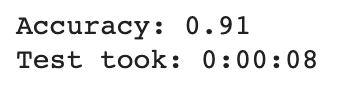

길이 조정된(128자) train data 30000개로 학습, 길이 조정된 test data 5000개 가량으로 테스트 결과

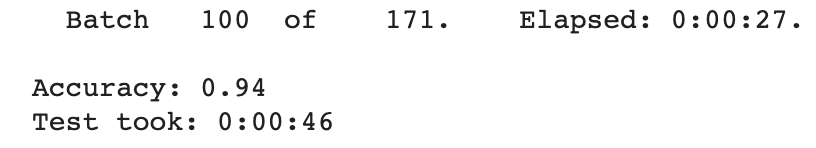

길이 조정된(128자) train data 30000개로 학습, *** 길이 조정되지 않은 *** test data 10000개 가량으로 테스트 결과

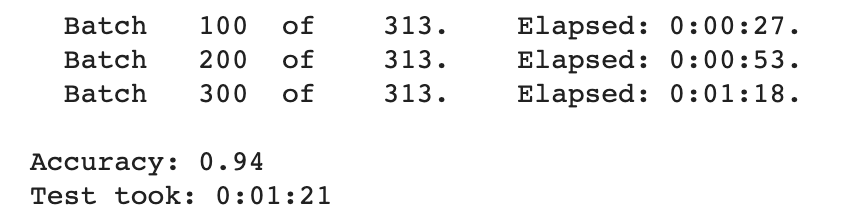